# 0. Setup

In [50]:
import nilearn
import pandas as pd
import numpy as np
import os

from nilearn import plotting
from nilearn import connectome
from nilearn import datasets
from nilearn import image



In [51]:
# Set the path to the data directory
src_dir = '../data/'

# Set the participant and session IDs
part_id = 'sub-01'
ses_id = 'ses-01'

# Path to the T1w image
anat_path = os.path.join(src_dir, part_id, ses_id, 'anat', f'{part_id}_{ses_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')

# Path to functional image
funcdir_path = os.path.join(src_dir, part_id, ses_id, 'func')

## 0.1 Anat

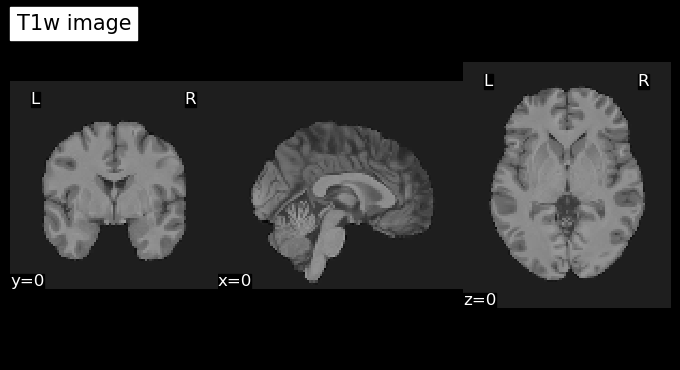

In [52]:
from nilearn.plotting import plot_anat

plot_anat(anat_path, title='T1w image', display_mode='ortho',  draw_cross=False,  cut_coords=(0, 0, 0))


In [53]:
# load the functional data

# list directory contents with extension 'nii.gz'
func_runs = os.listdir(funcdir_path)
func_runs = [f for f in func_runs if f.endswith('bold.nii.gz')]

# Sort the list
func_runs.sort()

print(func_runs)

['sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz']


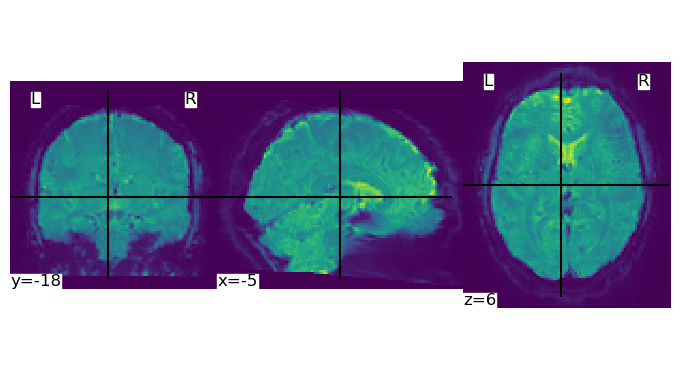

In [54]:
from nilearn.image import mean_img , load_img
from nilearn.plotting import plot_img

# Load the first functional image
func_image = image.load_img(os.path.join(funcdir_path,func_runs[0]))

mfunc_img = mean_img(func_image)

plot_img(mfunc_img)

# 1. Load Mask / atlas / meta

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

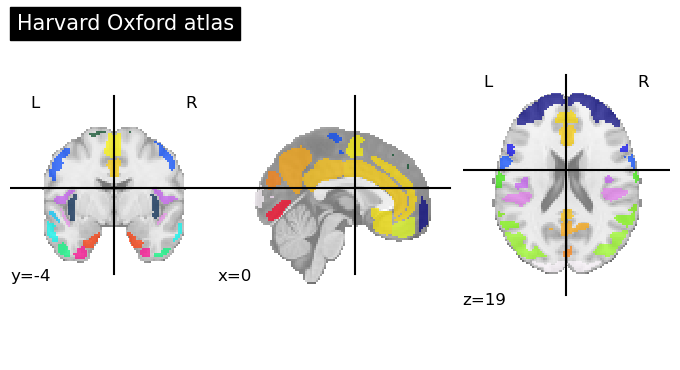

In [55]:
# load atlas
from nilearn import datasets
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas_filename = atlas.maps

# list of labels
labels = atlas.labels

print(labels)

# number of regions
number_of_regions = len(labels)
print(number_of_regions)

# plot the atlas
from nilearn import plotting
plotting.plot_roi(atlas_filename, title="Harvard Oxford atlas")

# 2. Extract timecourses per ROI / block

In [56]:
# extract time series from ROIs
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache')

time_series = masker.fit_transform(func_image)


In [57]:
fdir_events = [file for file in os.listdir(funcdir_path) if file.endswith('.tsv')]

f_events = [os.path.join(funcdir_path, f) for f in fdir_events]

f_events.sort()

print(f_events)


['../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-2_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-3_events.tsv', '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-4_events.tsv']


# 3. Compute connectivity

In [58]:
from nilearn.image import index_img 

# SELECT RUN!
# ------------

run_id = 0

# ------------

onset_set = {}
duration_set = {}

target_set = {}

idx = 0

offset_st = 4 # offset for the onset time
offset_end = 2 # offset for the end block time

# for each events file 
fn  = f_events[run_id]

print(os.path.join(funcdir_path,func_runs[run_id]), fn)

# Load the events.tsv file
events = pd.read_table(fn)

# create one image per event 
for i, row in events.iterrows():

    # Print the row information
    print(row) 

    # Extract the onset time
    onset = np.round(row['onset'])

    # Extract the duration
    duration = np.round(row['duration'])

    # Extract the trial_type
    trial_type = row['trial_type']

    # Print the row information
    print(onset, duration, trial_type) 

    # if duration greater than 10
    if duration > 10 and onset + duration + offset_end < 660:

        onset_set[idx] = onset + offset_st
        duration_set[idx] = duration - offset_st + offset_end

        target_set[idx] = trial_type


        idx += 1

../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv
onset           0.0
duration      12.25
trial_type    Noise
Name: 0, dtype: object
0.0 12.0 Noise
onset              12.25
duration            24.0
trial_type    Tenderness
Name: 1, dtype: object
12.0 24.0 Tenderness
onset         36.24
duration       5.93
trial_type    Noise
Name: 2, dtype: object
36.0 6.0 Noise
onset              42.18
duration           24.08
trial_type    Tenderness
Name: 3, dtype: object
42.0 24.0 Tenderness
onset         66.25
duration      17.99
trial_type    Noise
Name: 4, dtype: object
66.0 18.0 Noise
onset          84.25
duration       24.06
trial_type    Wonder
Name: 5, dtype: object
84.0 24.0 Wonder
onset         108.3
duration       5.98
trial_type    Noise
Name: 6, dtype: object
108.0 6.0 Noise
onset         114.28
duration       23.97
trial_type    Wonder
Name: 7, dtype: object

520 22 Tension
550 22 Tension
448 22 Power
478 22 Power
376 22 Sadness
406 22 Sadness
592 22 JoyfulActivation
622 22 JoyfulActivation
232 22 Peacefulness
262 22 Peacefulness
4 10 Noise
70 16 Noise
142 16 Noise
214 16 Noise
286 16 Noise
358 16 Noise
430 16 Noise
502 16 Noise
574 16 Noise
304 22 Transcendence
334 22 Transcendence
16 22 Tenderness
46 22 Tenderness
160 22 Nostalgia
191 22 Nostalgia
88 22 Wonder
118 22 Wonder


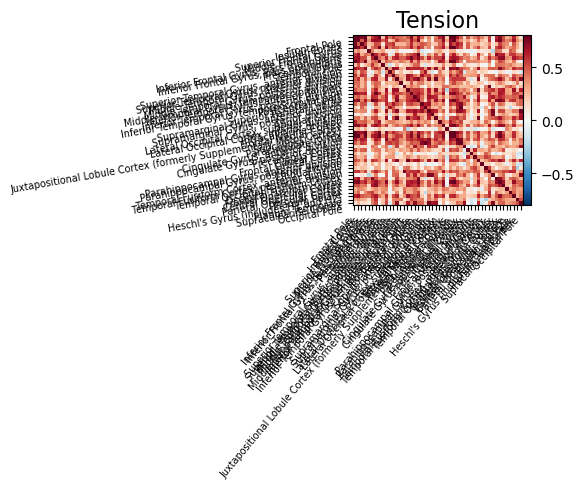

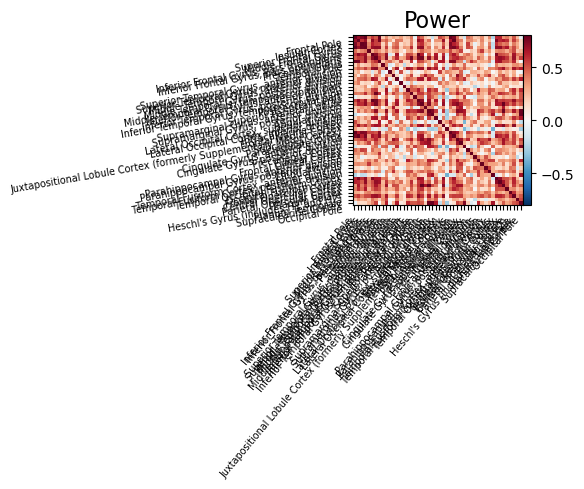

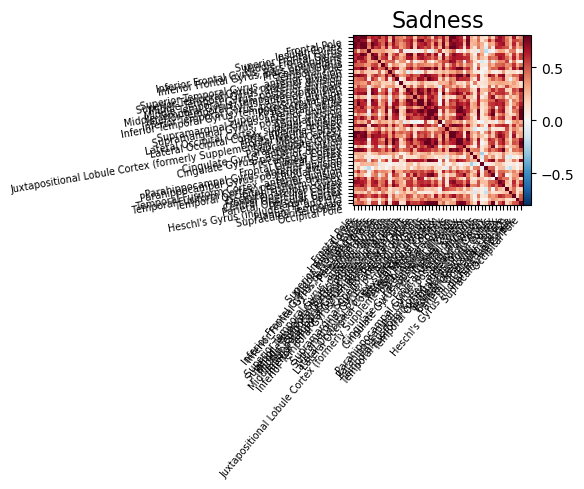

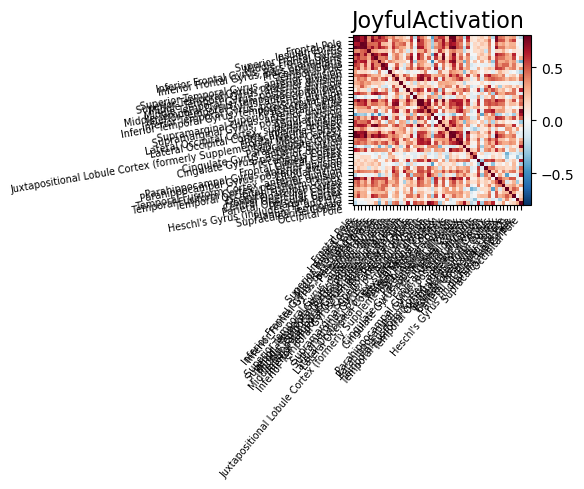

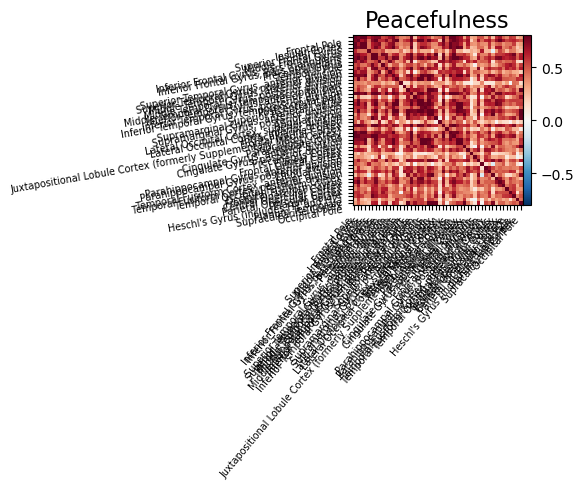

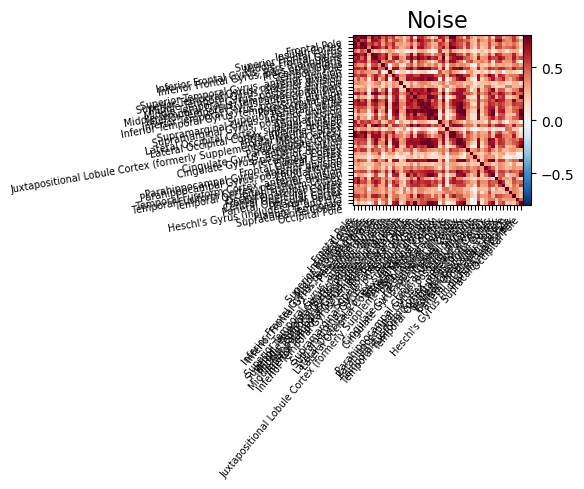

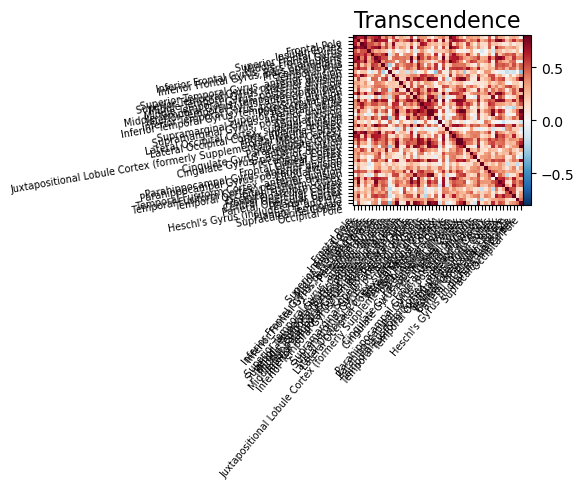

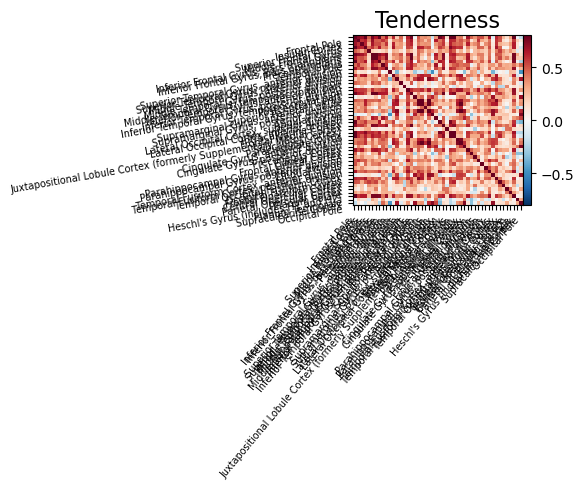

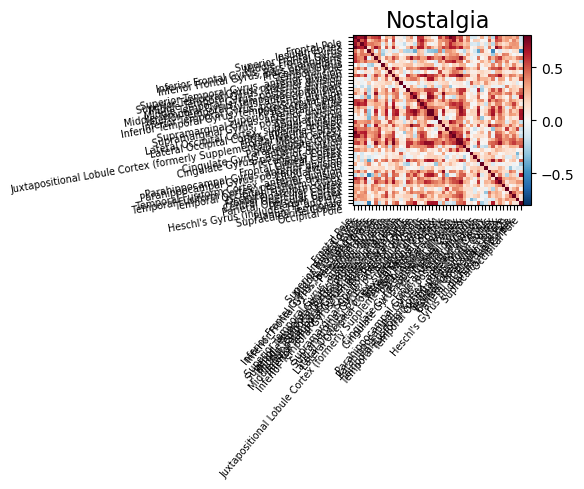

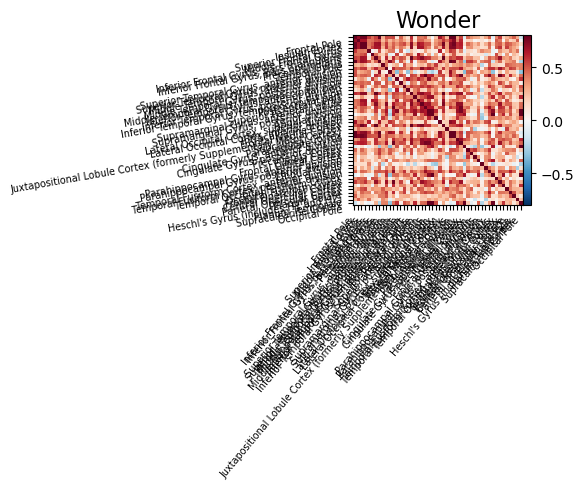

In [67]:
# Compute the correlation matrix considering onset, duration and type of events

# number of time series
number_of_regions = time_series.shape[1]

# create a list of target types
target_types = list(set(target_set.values()))

# Create a correlation matrix for each target type
for target in target_types:

    # Create a correlation matrix
    correlation_matrix = np.zeros((number_of_regions, number_of_regions))

    # Create a counter
    counter = 0

    # for each event
    for idx in onset_set:

        # if the target type is the same as the current event
        if target_set[idx] == target:

            # Extract the onset time
            onset = onset_set[idx]

            # Extract the duration
            duration = duration_set[idx]

            # print onset, duration and type of event
            print(int(onset), int(duration), target)

            # Extract the time series (cast onset and duration to int)

            time_series_event = time_series[int(onset):int(onset+duration)]

            # Compute the correlation matrix
            partial_correlation_matrix = np.corrcoef(time_series_event.T)

            # Add the partial correlation matrix to the correlation matrix
            correlation_matrix += partial_correlation_matrix

            # Increment the counter
            counter += 1

    # Normalize the correlation matrix
    correlation_matrix /= counter

    # Plot the correlation matrix
    plotting.plot_matrix(correlation_matrix, labels=labels[1:], vmax=0.8, vmin=-0.8, title=target)

    # Save the correlation matrix
    np.save(f'correlation_matrix_{target}.npy', correlation_matrix)

    # Save the correlation matrix as a nifti file
    correlation_matrix_img = masker.inverse_transform(correlation_matrix)

    correlation_matrix_img.to_filename(f'correlation_matrix_{target}.nii.gz')

    




In [ ]:
# Compute the correlation matrix for the entire time series
correlation_matrix = np.corrcoef(time_series.T)

(48, 48)


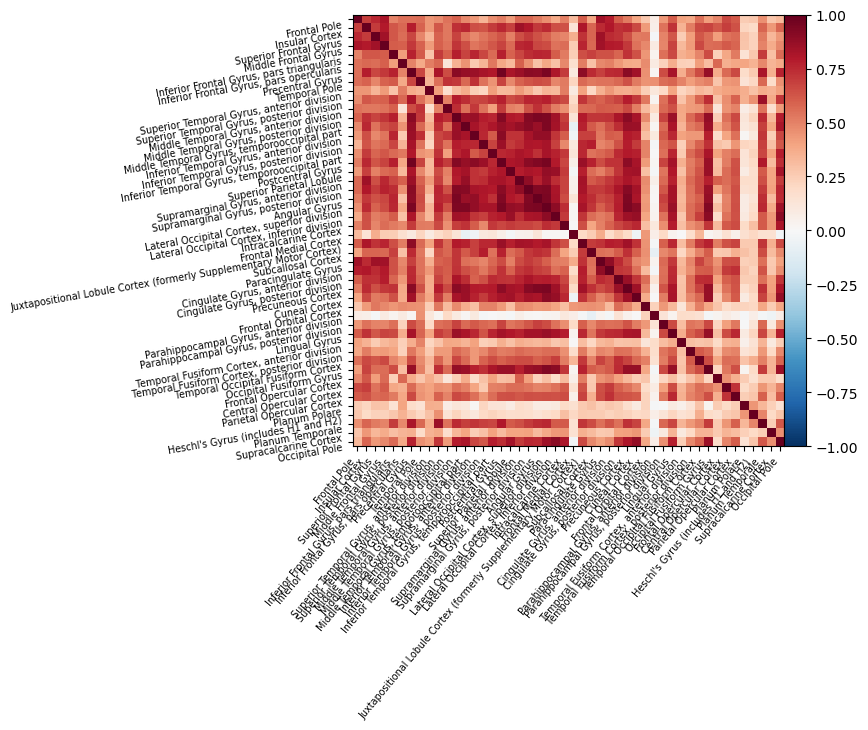

In [42]:
# size correlation_matrix
print(correlation_matrix.shape)

# plot the correlation matrix
from nilearn import plotting
plotting.plot_matrix(correlation_matrix, labels=labels[1:], colorbar=True, vmax=1, vmin=-1)

# 4. Compare emotions and save